# Simulator for *PLATYPUS* and *SPATZ*

The purpose of this notebook is to simulate a measurement on one of these two instruments at ACNS. Its deficiency is that it doesn't take into account systematic errors (such as misalignment, gravity effects) and can't do background subtractions. The latter is done during an experiment to decrease $R_{min}$, which has the effect of increasing error bar size.

In [1]:
%matplotlib inline
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from tof_simulator import ReflectSimulator, SpectrumDist

from refnx.reflect import Slab, Structure, SLD, ReflectModel
from refnx.dataset import ReflectDataset

Since *PLATYPUS* and *SPATZ* are time-of-flight instruments it's necessary to have a wavelength spectrum to be able to generate neutrons of different wavelength onto the sample. We take a direct beam spectrum and convert it into a probability distribution

The `SpectrumDist` object is a `scipy.stats` like object to describe the neutron intensity as a function of wavelength. You can use the `pdf, cdf, ppf, rvs` methods like you would a `scipy.stats` distribution. Of particular interest is the `rvs` method which randomly samples neutrons whose distribution obeys the direct beam spectrum. Random variates are generated the `rv_continuous` superclass by classical generation of uniform noise coupled with the `ppf`. `ppf` is approximated by linear interpolation of `q` into a pre-calculated inverse `cdf`. 

The `ReflectSimulator` class generates neutrons whose distribution follows the wavelength and angular resolution of the instrument. If uses those neutrons to calculate a reflectivity pattern based on a user supplied `ReflectModel`. The resolution properties of `ReflectModel` are ignored.

Generate the structure you want to simulate:

In [2]:
air = SLD(0)
sio2 = SLD(3.47)
si = SLD(2.07)

s = air | sio2(225, 3) | si(0, 3)
model = ReflectModel(s, bkg=5e-7)

Create the instrument simulator and sample. Here we sample at two angles of incidence. This would correspond to *roughly* 1200 s and 3600 s on Platypus. It's possible that the acquisition time/# of samples correspondence is up to an order of magnitude out.

In [3]:
simulator0 = ReflectSimulator(model, 0.65, direct_spectrum='PLP0000711.nx.hdf', rebin=2)
simulator1 = ReflectSimulator(model, 3, direct_spectrum='PLP0000711.nx.hdf', rebin=2)

In [4]:
simulator0.sample(2400000)
simulator0.sample_direct(1500000)
for i in tqdm(range(150)):
    # 150e6 beam monitor counts
    simulator1.sample(1000000)
simulator1.sample_direct(1500000)

100%|█████████████████████████████████████████| 150/150 [00:24<00:00,  6.13it/s]


The `ReflectSimulator.reflectivity` attribute is a `ReflectDataset`, which can have additional data spliced onto it.

In [5]:
data = ReflectDataset()
data += simulator0.reflectivity
data += simulator1.reflectivity

data.save('sim.txt')

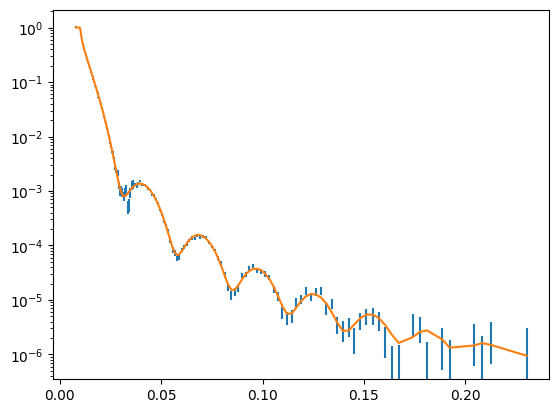

In [6]:
ebc = plt.errorbar(data.x, data.y, yerr=data.y_err)
ebc[0].set_linewidth(0)
plt.plot(data.x, model(data.x, x_err=data.x_err))
plt.yscale('log')

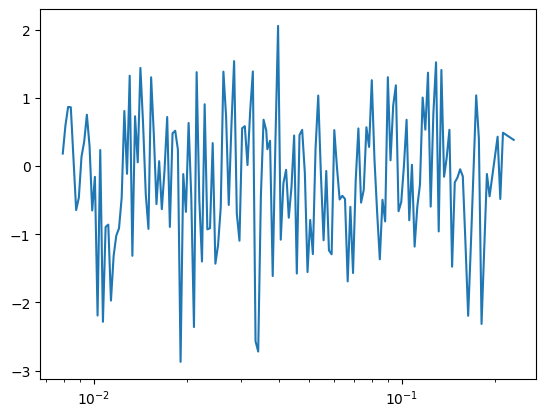

In [7]:
plt.plot(data.x, (data.y - model(data.x, x_err=data.x_err)) / data.y_err)
plt.xscale('log');